# Assignment 1
Submission DDL: 03.11.2024 23:59.
* For the tasks that require the text answer use *Insert* > *Text cell* and provide your answer in this cell. Text cell supports Markdown.
* Submit your work to the submission box on MyCourses. You should submit only the **.ipynb file** with your code.
* Before submission use *Runtime* > *Run all* to make sure that your notebook runs without errors.
* To download the file from Google Colab use *File* > *Download* > *Download .ipynb*.
* Submit the file with the name: A1_NAME_SURNAME_STUDENT NUMBER.ipynb

**NB! Before editing the file, save a local copy to your Google Drive, otherwise your progress will be lost**





## Task description
*wedeliver*, a food delivery company, has recently expanded to a new market with a city layout different to their homebase. The parametres for delivery time prediction, that are used in the other city, do not work well in the new location. Your task is to find the new parameters for the city and make the revenue sensitivty analysis.

The task consist of 3 parts:
* **A** – implementation of quantile regresion on test dataset (**5 points**)
* **B** – revenue general sensitivity analysis (**8 points**)
* **C** – revenue sensitivity analysis with target on specific areas (**7 points**)

Further description and specific instructions are provided within the course of the assignment. Places, where you need to write your code are commented with capital leters, e.g. #YOUR CODE HERE



In [50]:
# import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import QuantileRegressor, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

!pip install watermark

# magic methods
%matplotlib inline
%config InlineBackend.figure_format='retina' # high-resolution plots

In [51]:
student_number = 863522 # WRITE YOUR STUDENT NUMBER HERE. If it contains any letters, just omit them
assert type(student_number) is int, "Exclude letters, leave only numbers"

# watermark the code
%load_ext watermark
%watermark  -d -t -v -m -p numpy,pandas,sklearn,matplotlib,seaborn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy     : 1.26.4
pandas    : 2.2.2
sklearn   : 1.5.2
matplotlib: 3.8.0
seaborn   : 0.13.2

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.1.85+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



Next you will load the set of the previous orders, which you will use to obtain the estimates.

In [52]:
# load the train dataset from the github repo
url_train = "https://raw.githubusercontent.com/dsfb2/dsfb2-2024/main/assignment_1/data/a1_train.csv"
data_train = pd.read_csv(url_train, sep=";", index_col=0)

The dataset is simple, it contains only 2 columns: the delivery distance in kilometers and actual delivery time in minutes.
* **Task A1** – explore the dataset: provide the summary and visulize the data **(1 points)**

In [53]:
# YOUR CODE HERE FOR TASK A1 – SUMMARY
data_train.describe()

,distance,actual_delivery_time
count,3000.000000,3000.000000
mean,7.969326,21.338691
std,3.718042,7.369317
min,1.212815,6.774441
25%,5.192674,16.138103
50%,7.383778,20.296789
75%,9.956642,25.197016
max,27.248825,64.708509


In [54]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distance              3000 non-null   float64
 1   actual_delivery_time  3000 non-null   float64
dtypes: float64(2)
memory usage: 70.3 KB


Text(0, 0.5, 'Actual delivery time (mins)')

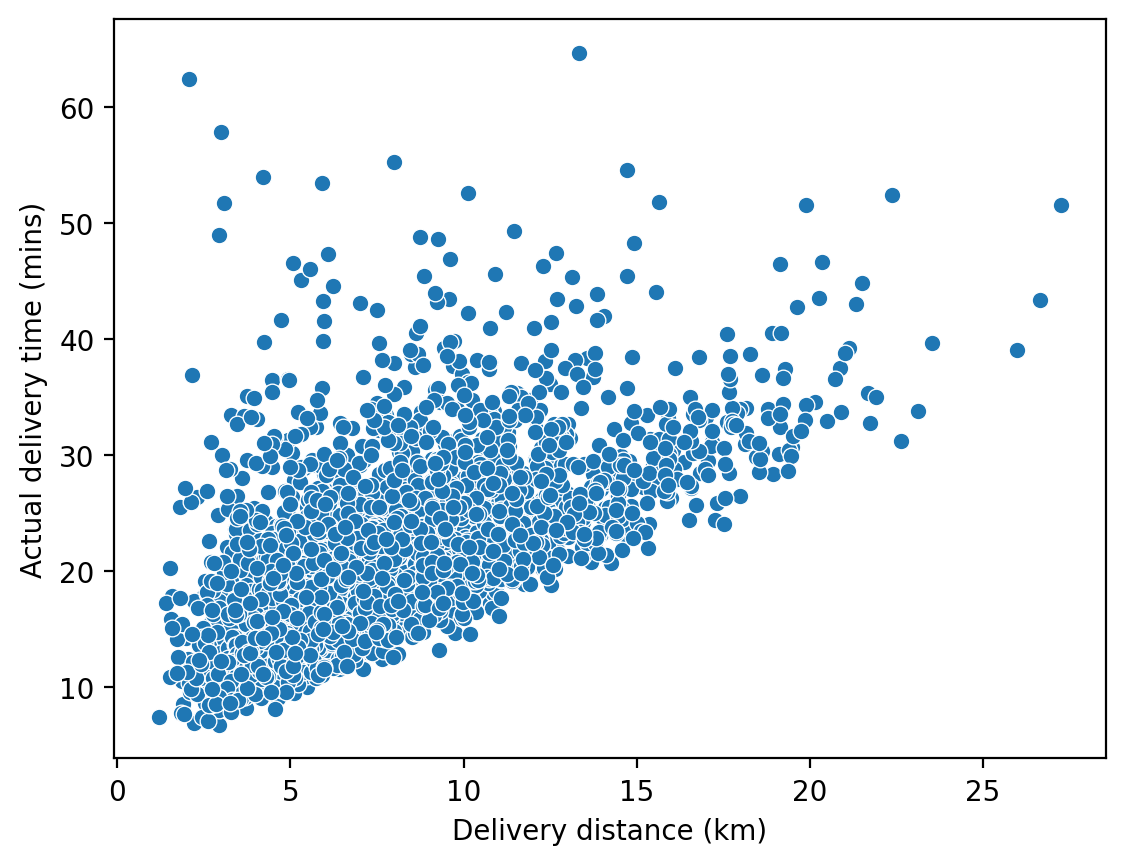

In [55]:
# YOUR CODE HERE FOR TASK A1 – VISUALIZATION
sns.scatterplot(data=data_train, x="distance", y="actual_delivery_time")
plt.xlabel("Delivery distance (km)")
plt.ylabel("Actual delivery time (mins)")
# ADD A VERBAL SUMMARY OF WHAT YOU'VE LEARNT ABOUT DATA (2-3 SENTENCES) TO AN EMPTY TEXT CELL BELOW

CELL FOR A SUMMARY

*   All datapoints are non-null.
*   Positive correlation between delivery time(mins) and delivery distance(km)
*   There might be some outliers


---
The interest of the company is to retain the newcoming customers. The previous analysis has shown, that customers are sensitive to the delivery time. The app, that the company provides, shows the delivery window when the order will arrive. The probability of the customer placing one more order depends on how well you've predicted the time window:
- if the order arrives early, the customer places a new order with p=0.16
- if the order arrives within 0%-25% of the time window, the customer places a new order with p=0.95
- if the order arrives within 25%-50% of the time window, the customer places a new order with p=0.9
- if the order arrives within 50%-75% of the time window, the customer places a new order with p=0.7
- if the order arrives within 75%-100% of the time window, the customer places a new order with p=0.65
- if the order arrives late, the customer places a new order with p=0.14

For example, you estimate the time windown for the order to arrive is 8 to 16 minutes
- if the order arrives in < 8 minutes, prob of a new order is 0.16
- if the order arrives in 8-10 minutes, prob of a new order is 95
- if the order arrives in 10-12 minutes, prob of a new order is 0.9
- if the order arrives in 12-14 minutes, prob of a new order is 0.7
- if the order arrives in 14-16 minutes, prob of a new order is 0.65
- if the order arrives in >16 minutes, prob of a new order is 0.14

Also customers do not like when the delivery window is too wide, so there is a penalty on the size that is reflected on the revenue.

Your aim is to figure out the time window that yields the highest revenue. The calculation is done on the test dataset, that will be introduced later.

---

At first, lets create the baseline. The company used to estimate quantile 0.3 for the lower bound of the time window and 0.8 for the upper bound of the time window.
* **Task A2** - estimate the upper and lower bound of the time window making the arrival time a linear function of the distance. For the lower bound use the 0.3 quantile, and for the upper bound use 0.8 quantile. **(4 points)**



In [56]:
# Create feature matrix

# YOUR CODE HERE
X_train = data_train["distance"].to_numpy().reshape(-1,1)
y_train = data_train["actual_delivery_time"]

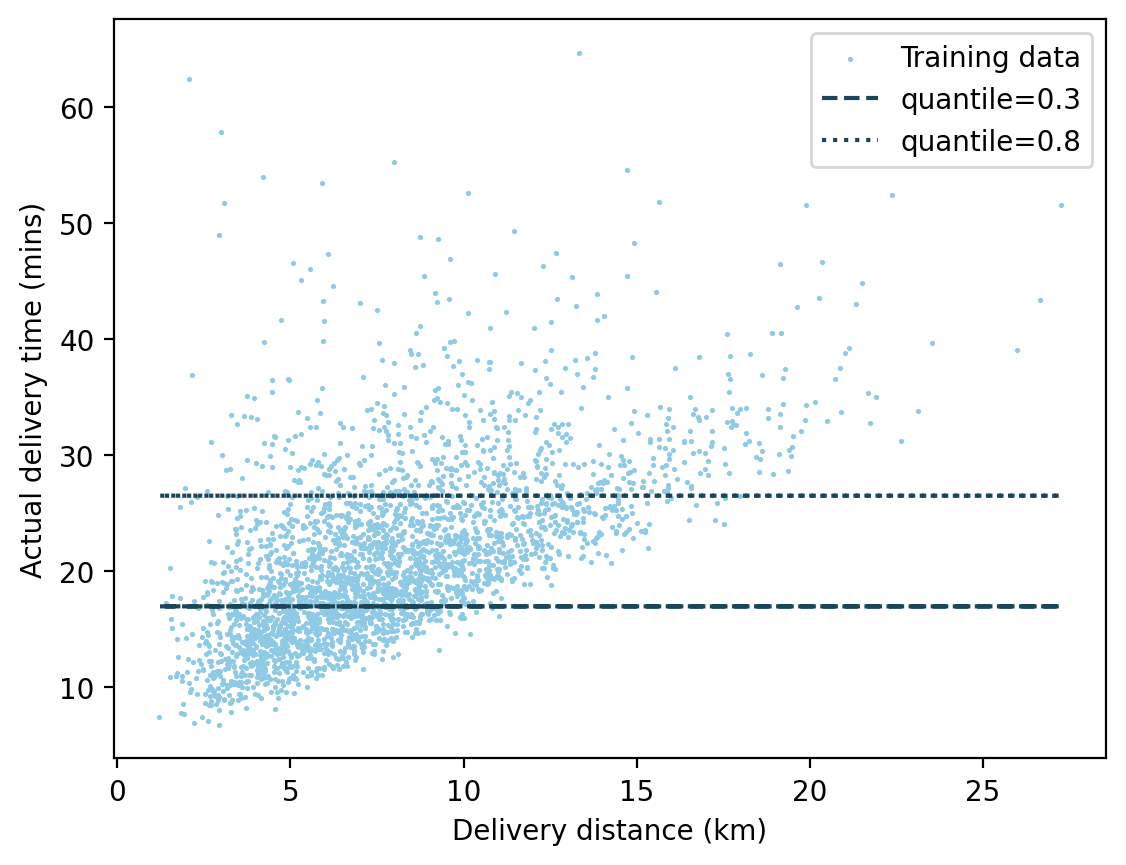

In [57]:
# Create an empty dictionary named predictions_base, where we store our results
predictions_base = {} # YOUR CODE HERE

# estimate the quantile regression for the lower bound, don't forget to use the parameter solver='highs' when you call QuantileRegressor() - it came in an update after the tutorial
lower_quantile_base = 0.3
qr_lower_base =  QuantileRegressor(quantile=lower_quantile_base, solver='highs') #YOUR CODE HERE
predictions_base[lower_quantile_base] = qr_lower_base.fit(X_train, y_train).predict(X_train) # YOUR CODE HERE

# estimate the quantile regression for the upper bound, don't forget to use the parameter solver='highs' when you call QuantileRegressor() - it came in an update after the tutorial
upper_quantile_base = 0.8
qr_upper_base = QuantileRegressor(quantile=upper_quantile_base, solver = 'highs')# YOUR CODE HERE
predictions_base[upper_quantile_base] = qr_upper_base.fit(X_train, y_train).predict(X_train) # YOUR CODE HERE
# YOUR CODE HERE

# Visualize the estimated quantiles
plt.scatter(data_train["distance"], data_train["actual_delivery_time"], color = '#8ecae6', marker = '.', s=3, label = "Training data")
plt.plot(X_train, predictions_base[lower_quantile_base], color = '#1b4559', linestyle="dashed", label = f"quantile={lower_quantile_base}")
plt.plot(X_train, predictions_base[upper_quantile_base], color = '#1b4559', linestyle="dotted", label = f"quantile={upper_quantile_base}")
plt.xlabel("Delivery distance (km)")
plt.ylabel("Actual delivery time (mins)")
plt.legend()


In [58]:
# functions to calculate the revenue
# DO NOT MODIFY THE CELL

# probability to place the next using the parameters described earlier
def prob_calc(df):
  df["stand"] = (df.actual_time-df.lower_bound) / (df.upper_bound-df.lower_bound)
  bins = [-float("inf"), 0, 0.25, 0.5, 0.75, 1,float("inf")] # -float("inf"): negative infinity
  labels = [0.16, 0.95, 0.9, 0.7, 0.65, 0.14]

  df['prob'] = pd.cut(df['stand'], bins, labels=labels).astype(float)
  return df.prob

# calculate revenue based on the orders that are placed
# function takes the QuantileRegressor objects with `fit` method for lower and upper quantiles as well as the difference between the values of upper and lower quantile
def calculate_revenue(regressor_lower_quantile_fit, regressor_upper_quantile_fit, q_diff):
  url_test = "https://raw.githubusercontent.com/dsfb2/dsfb2-2024/main/assignment_1/data/a1_test.csv"
  df_test = pd.read_csv(url_test, sep=";")
  X_test = df_test["distance"].to_numpy().reshape(-1,1)
  df_test["lower_bound"] = regressor_lower_quantile_fit.predict(X_test)
  df_test["upper_bound"] = regressor_upper_quantile_fit.predict(X_test)
  df_test["prob"] = prob_calc(df_test)
  df_test["pred_order"] = df_test.prob.apply(lambda x: np.random.default_rng(seed=student_number).binomial(1, x, 1)[0])

  customer_id = 0
  df_test['new_order'] = np.nan

  for i in range(len(df_test.customer_id)):
    if df_test.loc[i, 'customer_id'] == customer_id:
      df_test.loc[i, 'new_order'] = np.minimum(df_test.loc[i, 'pred_order'], df_test.loc[i-1, 'new_order'])
    else:
      customer_id = df_test.loc[i, 'customer_id']
      df_test.loc[i, 'new_order'] = df_test.loc[i, 'pred_order']

  revenue = sum(df_test.order_value*df_test.new_order)*(1-2*q_diff/3)

  return np.around(revenue, 2)

In [59]:
# Now lets see what are the revenue based on the current time window parameters
base_revenue = calculate_revenue(qr_lower_base.fit(X_train, y_train), qr_upper_base.fit(X_train, y_train), upper_quantile_base-lower_quantile_base)
print(f'Current revenue: {base_revenue}\n')


url_test = "https://raw.githubusercontent.com/dsfb2/dsfb2-2024/main/assignment_1/data/a1_test.csv"
df_test = pd.read_csv(url_test, sep=";")
df_test.head()

Current revenue: 112805.67



,customer_id,distance,order_value,focus,actual_time
0,793,7.781171,19.599293,0,24.619998
1,828,5.887054,21.527991,0,14.197788
2,238,10.330256,18.540962,0,17.924817
3,286,11.369525,21.244396,0,21.900126
4,558,5.964555,27.994735,0,18.344167


You have just seen how much revenue the company earns using the old approach. The test data set used for the revenue evaluation contains information about 1000 customers who place 12000 orders. If a customer stops ordering, all future orders of this customer will not bring the company any revenue. The probability of placing the next order is based on the actual arrival time of the courier and the time window limits that you predict using the quantile regression.

NOTE: The amount of revenue may differ from your peers because the seed for the binomial distribution used to calculate whether a new order will be placed based on the probability of placement is your student number.

Now that you know the baseline, you will perform the revenue sensitivity analysis

**Task B** – conduct revenue sensitivity analysis **(8 points)**

You should explore how revenue changes as the upper and lower bounds of the time window are changed. Use different quantiles to estimate the bounds and use the `calculate_revenue()` function to calculate the revenue. Visualize the results of your analysis with the graphs of your choice. In a text cell, write a short report (about 10 sentences) on how revenue responds to the choice of quantiles. Try widening and narrowing the window and moving up and down the quantiles. Please use quantiles with a maximum precision of 2 decimal points (e.g. 0.31).

The points are distributed ias follows:
- Clarity and correcteness of code **(2 points)**
- Vizualization of results **(3 points)**
- Report of the results and discussion on revenue sensitivity  **(3 points)**

It is important that you explain the approach you take and the results you get. Even if you do not find the global optimum, it is totally fine as long as you explain what, why and how you do and what you get then.

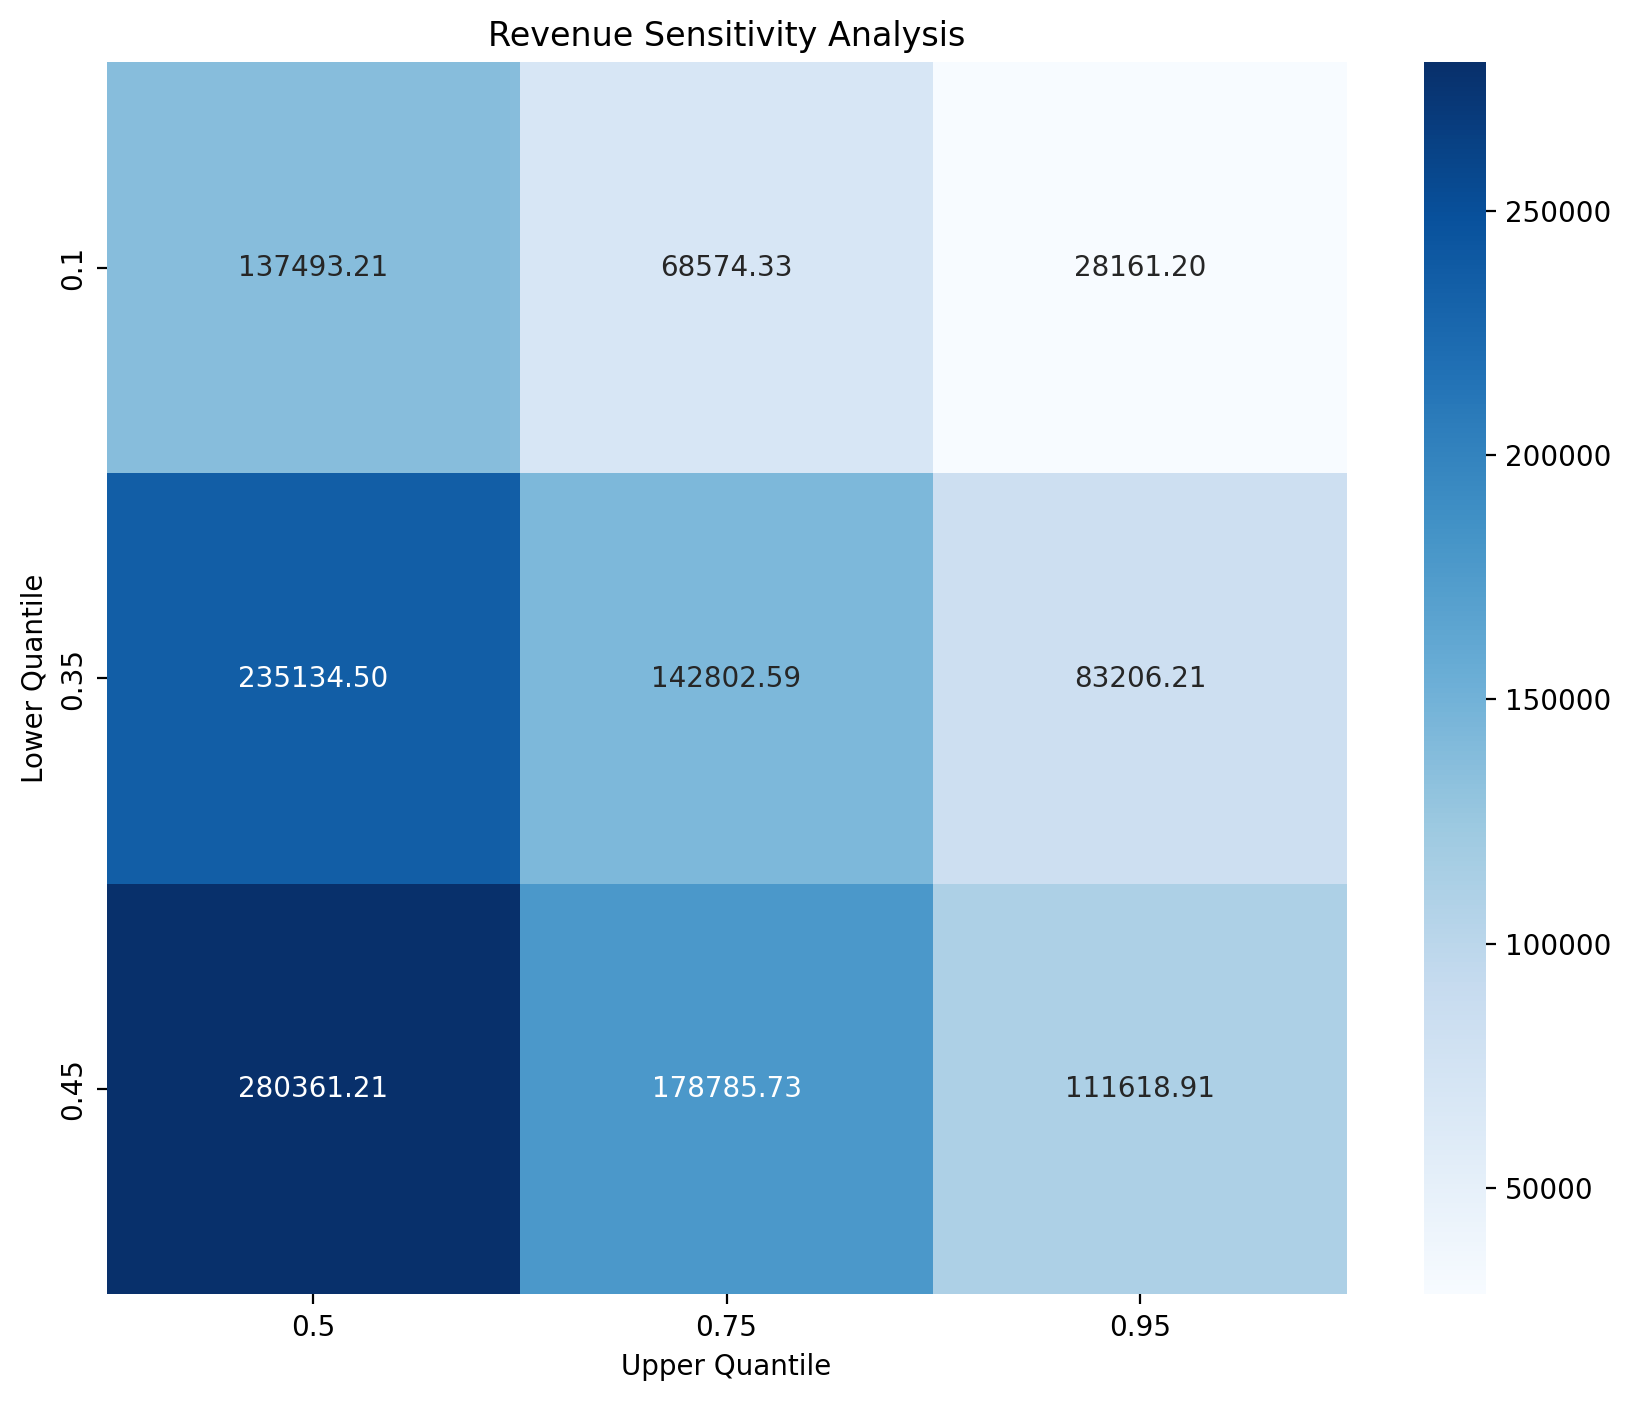

In [60]:
predictions = [] # YOUR CODE HERE

lower_quantile_base = [0.1, 0.35, 0.45]
upper_quantile_base = [0.5, 0.75, 0.95]
for i in lower_quantile_base:
  for j in upper_quantile_base:
    qr_lower_base =  QuantileRegressor(quantile= i, solver='highs') #YOUR CODE HERE
    qr_lower_base.fit(X_train, y_train) # YOUR CODE HERE

    qr_upper_base = QuantileRegressor(quantile= j, solver = 'highs')# YOUR CODE HERE
    qr_upper_base.fit(X_train, y_train) # YOUR CODE HERE

    revenue = calculate_revenue(qr_lower_base, qr_upper_base, j-i)
    predictions.append([i, j, revenue])

predictions_df = pd.DataFrame(predictions, columns = ['lower_quantile', 'upper_quantile', 'revenue'])
pivoted_df = predictions_df.pivot(index='lower_quantile', columns='upper_quantile', values='revenue')
# Visualize the estimated quantiles
plt.figure(figsize=(10, 8))
sns.heatmap(pivoted_df, annot=True, fmt=".2f", cmap="Blues")
plt.title('Revenue Sensitivity Analysis')
plt.xlabel('Upper Quantile')
plt.ylabel('Lower Quantile')
plt.show()




*   Revenue is associated with quantile value
*   when the window is 0.45-0.5, the revenue is highest. While when its 0.1 - 0.95, revenue is lowest
*   In general, the higher the lower quantile bound is, the higher the revenue is. However, the higher the upper quantile bound is, the lower the revenue is.

When the lower-quantile bound and upper-quantile bound are both close to the median, the window is very short. Short window gets low penalty. If the model predicts very accurately, a narrow window can work pretty well. It suggests that the benifit of a narrow window outweigh the risks of deliveries falling due.

However, in real-life cases, it is rarely the case that delivery can go as expected fully. The result might also change when a different dataset is used. Further analysis is needed for a more accurate explaination.






CELL FOR THE REPORT

- **Task C** revenue sensitivity analysis with target on specific areas **(7 points)**

After studying the general situation, you receive input from your operations team. From their metrics, they see that the couriers tend to skip less orders with delivery distance less than 7 km and order value over 30 EUR. The team asks you to take a closer look at these customers. In your training data you do not have the order values, so you can only rely on the distance. Your task is to see if you can offer these customers a slightly different time window in order to increase their loyalty and the revenue of your company. The assignment will be scored as follows
 The task will be evaluated as follows:

- Clarity and correcteness of code **(2 points)**
- Vizualization of results **(2 points)**
- Report of the results and discussion on revenue sensitivity with treatment  **(3 points)**

Below is a new revenue calculation function. Now you need to pass the estimators for the special treatment group to the function. The report should also be about 10 sentences long.

It is important that you explain the approach you take and the results you get. Even if you do not find the global optimum, it is totally fine as long as you explain what, why and how you do and what you get then.

In [61]:
# calculate revenue based on the orders that are placed
def calculate_revenue_focus(regressor_lower_quantile_fit, regressor_upper_quantile_fit, q_diff, regressor_lower_focus, regressor_upper_focus):
  url_test = "https://raw.githubusercontent.com/dsfb2/dsfb2-2024/main/assignment_1/data/a1_test.csv"
  df_test = pd.read_csv(url_test, sep=";")
  X_test = df_test["distance"].to_numpy().reshape(-1,1)
  df_test["lower_bound_usual"] = regressor_lower_quantile_fit.predict(X_test)
  df_test["upper_bound_usual"] = regressor_upper_quantile_fit.predict(X_test)
  df_test["lower_bound_focus"] = regressor_lower_focus.predict(X_test)
  df_test["upper_bound_focus"] = regressor_upper_focus.predict(X_test)
  df_test["lower_bound"] = np.where(df_test["focus"]==1 , df_test["lower_bound_focus"] , df_test["lower_bound_usual"])
  df_test["upper_bound"] = np.where(df_test["focus"]==1 , df_test["upper_bound_focus"] , df_test["upper_bound_usual"])
  df_test["prob"] = prob_calc(df_test)
  df_test["pred_order"] = df_test.prob.apply(lambda x: np.random.default_rng(seed=student_number).binomial(1, x, 1)[0])

  customer_id = 0
  df_test['new_order'] = np.nan

  for i in range(len(df_test.customer_id)):
    if df_test.loc[i, 'customer_id'] == customer_id:
      df_test.loc[i, 'new_order'] = np.minimum(df_test.loc[i, 'pred_order'], df_test.loc[i-1, 'new_order'])
    else:
      customer_id = df_test.loc[i, 'customer_id']
      df_test.loc[i, 'new_order'] = df_test.loc[i, 'pred_order']

  revenue = sum(df_test.order_value*df_test.new_order)*(1-2*q_diff/3)

  return np.around(revenue, 2)

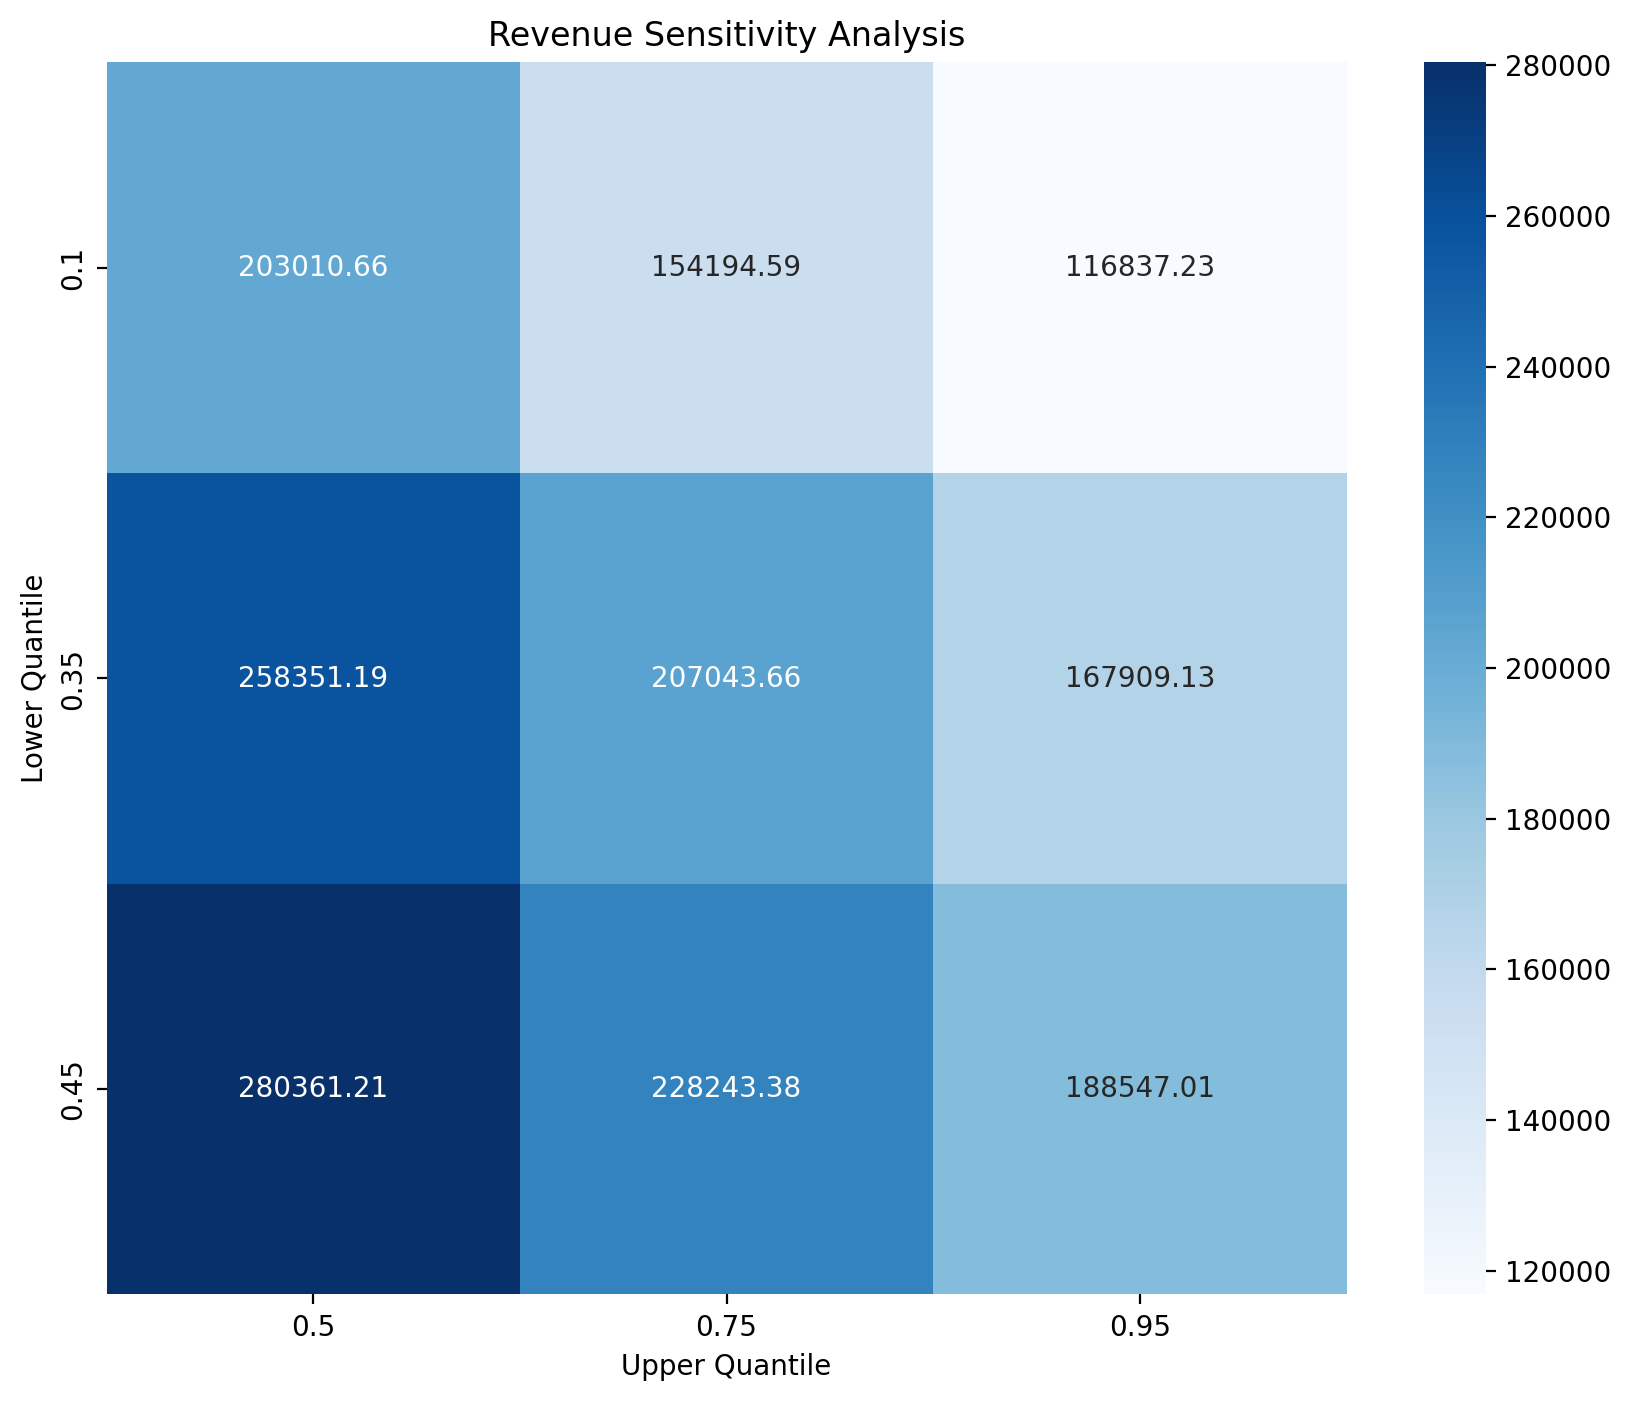

In [62]:

data_train["focus"] = (data_train["distance"] < 7).astype(int)
data_train.head()

X_train_focus = data_train[data_train["focus"] == 1]["distance"].to_numpy().reshape(-1,1)
y_train_focus = data_train[data_train["focus"] == 1]["actual_delivery_time"]

X_train_usual = data_train[data_train["focus"] == 0]["distance"].to_numpy().reshape(-1,1)
y_train_usual = data_train[data_train["focus"] == 0]["actual_delivery_time"]

lower_quantile_base = [0.1, 0.35, 0.45]
upper_quantile_base = [0.5, 0.75, 0.95]
predictions = []
for lower_q in lower_quantile_base:
  for upper_q in upper_quantile_base:
    qr_lower_base_focus =  QuantileRegressor(quantile= lower_q, solver='highs') #YOUR CODE HERE
    qr_lower_base_focus.fit(X_train, y_train) # YOUR CODE HERE

    qr_upper_base_focus = QuantileRegressor(quantile= upper_q, solver = 'highs')# YOUR CODE HERE
    qr_upper_base_focus.fit(X_train, y_train) # YOUR CODE HERE

    qr_lower_base =  QuantileRegressor(quantile= 0.45, solver='highs') #YOUR CODE HERE
    qr_lower_base.fit(X_train, y_train) # YOUR CODE HERE

    qr_upper_base = QuantileRegressor(quantile= 0.5, solver= 'highs')# YOUR CODE HERE
    qr_upper_base.fit(X_train, y_train) # YOUR CODE HERE

    q_diff = upper_q - lower_q
    revenue = calculate_revenue_focus(qr_lower_base, qr_upper_base, q_diff, qr_lower_base_focus, qr_upper_base_focus)
    predictions.append([lower_q, upper_q, revenue])

predictions_df = pd.DataFrame(predictions, columns = ['lower_quantile', 'upper_quantile', 'revenue'])
pivoted_df = predictions_df.pivot(index='lower_quantile', columns='upper_quantile', values='revenue')

# Visualize the estimated quantiles
plt.figure(figsize=(10, 8))
sns.heatmap(pivoted_df, annot=True, fmt=".2f", cmap="Blues")
plt.title('Revenue Sensitivity Analysis')
plt.xlabel('Upper Quantile')
plt.ylabel('Lower Quantile')
plt.show()




Applying a tailored approach to the focus group lead to increased total revenue.

Primarily focused on finding the optimal time window for the focus group (customers with delivery distances less than 7 km), while keeping the time window for the usual group (the rest of the customers) relatively stable(0,45, 0.5), which leads to the highest revenue without focus group.

In calculation of total revenue, the range of bounds of the focus group is used to focus on analyzing the impact of the focus group's window.

The highest total revenue quantile bounds suggest that it is still optimal to use 0.45 to 0.5 as window without addressing the focus group. When optimal window for usual and target group are the same, the benefit of tailoring the time window for the focus group might be large enough to outweight the potential downsides.

The result implies a more accurate or narrower time window could lead to higher customer satisfaction within or outside the focus group.



CELL FOR THE REPORT